In [2]:
%env CUDA_VISIBLE_DEVICES=0
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
import os
sys.path.append(os.path.expanduser("~.local/lib/python3.6/site-packages/"))

env: CUDA_VISIBLE_DEVICES=0
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import tables

from tqdm import trange

In [5]:
train_file = os.path.expanduser("~/data/MLHEP2018/train_1-2.hdf5")
test_file = os.path.expanduser("~/data/MLHEP2018/test_1-2.hdf5")
submission_file = 'submission_1-2.hdf5'

CROP_SIZE=19

## Read train file and plot energy deopsition and label pictures

In [6]:
f=tables.open_file(train_file, 'r')

In [9]:
event_index = 15
crop = f.root.data[event_index]
data_labels = f.root.label[event_index]

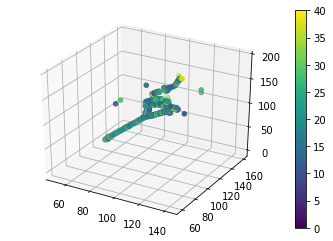

In [10]:
#crop = X_train[0]
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
x,y,z = np.where(crop>0)
v=crop[crop>0]
cv = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=40)
plt.colorbar(cv)
plt.show()

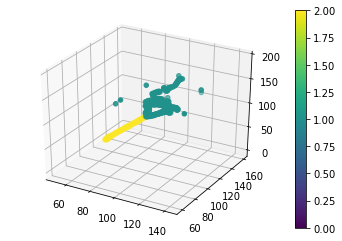

In [11]:
#crop = X_train[0]
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
x,y,z = np.where(crop>0)
v=data_labels[crop>0]
cl = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=2)
plt.colorbar(cl)
plt.show()

## We will be segmentioning event in the following way:
- For each non zero pixel in the event:
 * Cut the box of size (CROP_SIZE, CROP_SIZE, CROP_SIZE) with the pixel being in the center of the box
 * Train 3D convolutional net on such boxes - the output of the net is the probability that this pixel belongs to particular class
 * Apply this procedure to all pixels in all events

In [38]:
def make_crops(images, size=19):
    crops = np.zeros(((images > 0).sum() , 1, size, size, size))
    half_size = size // 2
    calc = 0
    for image in images:
        image = np.pad(image, ((0,0), (half_size, half_size), (half_size, half_size), (half_size, half_size)),
                       'constant', constant_values=0)
        
        non_zero_pixels = np.array(np.where(image[0] > 0)).T    
        for row in non_zero_pixels:
            crops[calc] = image[0, row[0] - half_size : row[0] + half_size + 1,
                                   row[1] - half_size : row[1] + half_size + 1,
                                   row[2] - half_size : row[2] + half_size + 1]
            calc += 1
            
    
    return crops

def read_events(start_index=0, end_index=100, energy_scale=255):
    X_train, y_train = [], []
    for event_index in trange(start_index, end_index):
        data_hits = np.expand_dims(np.array(f.root.data[event_index : event_index + 1]), axis=1)
        data_hits = data_hits * energy_scale / data_hits.max(axis=(1,2,3,4), keepdims=True)
        data_labels = np.expand_dims(np.array(f.root.label[event_index : event_index + 1]), axis=1)
        X_train.append(make_crops(data_hits, size=CROP_SIZE))
        y_train.append(data_labels[data_hits > 0] - 1)
#         else:
#             X_train = np.vstack((X_train, make_crops(data_hits, size=CROP_SIZE)))
#             y_train = np.hstack((y_train, data_labels[data_hits > 0] - 1))
    return np.concatenate(X_train), np.concatenate(y_train)

## We will make train and validation set from initial train set, since we want to estimate performace of algorithm on some hold-out data

In [39]:
%%time
X_train, y_train = read_events(start_index=0, end_index=100, energy_scale = 255)
X_val, y_val = read_events(start_index=300, end_index=400, energy_scale = 255)

100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


CPU times: user 1min 10s, sys: 27.6 s, total: 1min 37s
Wall time: 1min 38s


In [40]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, np.unique(y_train), np.unique(y_val)

((80640, 1, 19, 19, 19),
 (81929, 1, 19, 19, 19),
 (80640,),
 (81929,),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32))

In [41]:
f.close()

## Model

The model is simple - it is just classic case of convolutional net, but for 3D space

In [42]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [43]:
keras_settings = {
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_first"    
}

import json
with open(os.path.expanduser('~/.keras/keras.json'), 'w') as outfile:
    json.dump(keras_settings, outfile)

In [44]:
import keras
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
K.set_image_data_format('channels_first')


### Define model

In [45]:
def generate_block(in_channels, out_channels, k_size=3, pool=False, first_layer=False):
    model = Sequential()
    if first_layer:
        model.add(Conv3D(out_channels,
                         kernel_size=(k_size, k_size, k_size), input_shape=(in_channels,
                                                                            CROP_SIZE, CROP_SIZE, CROP_SIZE)))        
    else:
        model.add(Conv3D(out_channels,
                         kernel_size=(k_size, k_size, k_size)))


    if pool:
        model.add(MaxPooling3D(2))
    model.add(BatchNormalization(axis=1))
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    return model

model = Sequential([
    generate_block(1, 32, pool=True, first_layer=True),
    generate_block(32, 64, pool=False),
    generate_block(64, 128, pool=False),
    generate_block(128, 128, pool=False),
    MaxPooling3D(2),    
    Flatten(),
    Dense(128, input_shape=(128,)),
    Activation("relu"),
    Dropout(rate=0.5),
    Dense(256),
    Activation("relu"),
    Dense(1),
    Activation("sigmoid")
])

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6))

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 8, 8, 8)       1024      
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 6, 6, 6)       55616     
_________________________________________________________________
sequential_3 (Sequential)    (None, 128, 4, 4, 4)      221824    
_________________________________________________________________
sequential_4 (Sequential)    (None, 128, 2, 2, 2)      443008    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 128, 1, 1, 1)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [47]:
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

## Define training parameters

In [48]:
import time
#from pandas import ewma
from IPython import display

num_epochs = 1
batch_size = 128

train_loss = []
val_accuracy = []
val_roc = []

## Train the model. During training we will be plotting the training loss and validation accuracy and ROCAUC

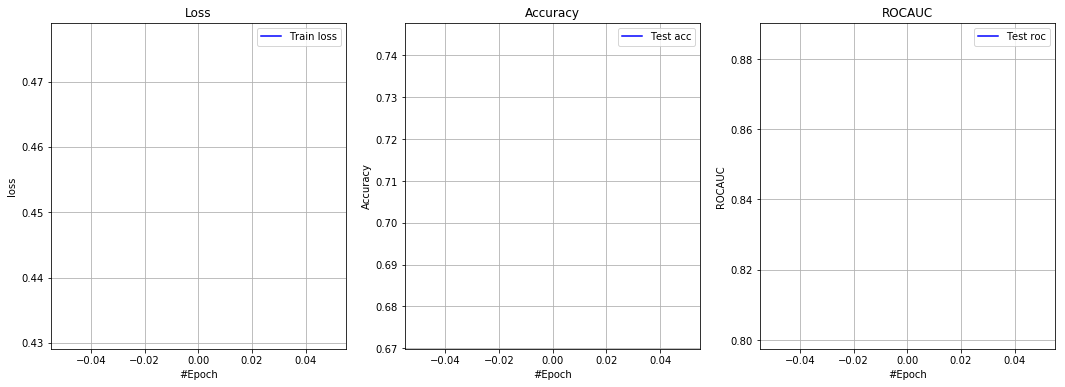

Epoch 1 of 1 took 70.547s
  training loss (in-iteration): 	0.454055
  validation accuracy:		70.89 %
  validation ROCAUC:		84.39 %


In [49]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    
    epoch_loss = 0
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        epoch_loss += model.train_on_batch(X_batch, y_batch)
        
    train_loss.append(epoch_loss / (len(X_train) // batch_size + 1))
        
        
    y_score = []
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        logits = model.predict_on_batch(X_batch)
        y_score.extend(logits)
    
    y_score = np.asarray(y_score)
    val_accuracy.append(np.mean((y_score[:,0] > 0.5) == y_val))
    val_roc.append(roc_auc_score(y_val, y_score))
    # Visualize
    
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss, 'b', label='Train loss')
    ax1.legend(loc='best')
    ax1.grid()

    ax2.set_title("Accuracy")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(val_accuracy, 'b', label='Test acc')
    ax2.legend(loc='best')
    ax2.grid()   
    
    ax3.set_title("ROCAUC")
    ax3.set_xlabel("#Epoch")
    ax3.set_ylabel("ROCAUC")
    ax3.plot(val_roc, 'b', label='Test roc')
    ax3.legend(loc='best')
    ax3.grid()      

    plt.show()
            
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        train_loss[-1]))
    print("  validation accuracy:\t\t{:.2f} %".format(val_accuracy[-1] * 100))
    print("  validation ROCAUC:\t\t{:.2f} %".format(val_roc[-1] * 100))

In [50]:
# Make sure we have save the model to be able to reproduce results later
model.save("dummy_model.ker")

In [51]:
y_score = []
for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
    logits = model.predict_on_batch(X_batch)
    y_score.extend(logits)

y_score = np.asarray(y_score)
accuracy_score(y_val, y_score > 0.5)

100%|██████████| 641/641 [00:18<00:00, 35.12it/s]


0.7088576694454954

## run model over test set

In [71]:
f=tables.open_file(test_file, 'r')

In [124]:
energy_scale = 255
threshold = 0.5

test_size = 10#f.root.data.shape[0]
image_size = f.root.data.shape[1:]

predictions = np.zeros((test_size, 1, *image_size), dtype=int)

for index in trange(test_size):
    data_hits = np.expand_dims(np.array(f.root.data[index:index + 1]), axis=1)
    data_hits = data_hits * energy_scale / data_hits.max(axis=(1,2,3,4), keepdims=True)

    mask = np.where(data_hits > 0)
    crop = make_crops(data_hits, size=CROP_SIZE)
    preds = (model.predict(crop)[:,0] > threshold) + 1
    predictions[index][mask[1:]] = preds

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


In [125]:
np.unique(predictions[5])

array([0, 1, 2])

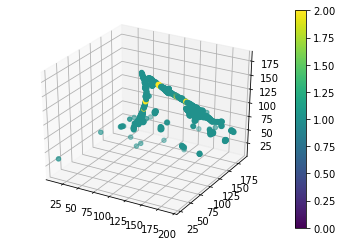

In [129]:
event = 8
crop = np.array(f.root.data[event])
#crop = X_train[0]
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
x,y,z = np.where(crop>0)
v=predictions[event][0][crop>0]
cl = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=2)
plt.colorbar(cl)
plt.show()

In [130]:
f.close()

In [131]:
from tqdm import tqdm

Save results to submission file

In [132]:
import tables
expectedrows = len(predictions)
FILTERS = tables.Filters(complevel=5, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None)
f_submission = tables.open_file(submission_file, 'w', filters=FILTERS)
preds_array = f_submission.create_earray('/', 'pred', tables.UInt32Atom(), (0,192,192,192), expectedrows=expectedrows)

for i in tqdm(range(expectedrows)):
    preds_array.append(predictions[i])

preds_array.close()
f_submission.close()

100%|██████████| 10/10 [00:02<00:00,  4.89it/s]
